# Reinforced learning, työllistyminen ja Suomen sosiaaliturva

Tässä tehdään laskelmat artikkelia varten. Käytössä on gym-ympäristö _unemployment-v1_ , johon on toteutettu yksityiskohtaisempi työttömyysturvamalli.

In [1]:
# for Colab, install fin_benefits and unemployment-gym from Github
#!pip install -q git+https://github.com/ajtanskanen/benefits.git  
#!pip install -q git+https://github.com/ajtanskanen/econogym.git
#!pip install -q git+https://github.com/ajtanskanen/lifecycle-rl.git

# and then restart kernel
  
  # For a specific version:
#!pip install tensorflow==1.15
#!pip install stable-baselines==2.8
  
# restart kernel after running pip's

Then load all modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lifecycle_rl import Lifecycle

%matplotlib inline
%pylab inline

# varoitukset piiloon (Stable baseline ei ole vielä Tensorflow 2.0-yhteensopiva, ja Tensorflow 1.5 valittaa paljon)
import warnings
warnings.filterwarnings('ignore')

pop_size=10_000
size1=20_000_000
size2=50_000_000
batch1=1
batch2=1000
deterministic=False # use deterministic prediction (True) or probabilitic prediction (False)
mortality=False # include mortality in computations
randomness=True # include randomness in the state transitions (e.g., maternity leave)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Populating the interactive namespace from numpy and matplotlib


# Nykymalli 

Lasketaan työllisyysasteet nykymallissa.

In [5]:
cc1=Lifecycle(env='unemployment-v1',minimal=False,mortality=mortality,perustulo=False,
              deterministic=deterministic,randomness=randomness)

cc1.explain()
cc1.run_results(debug=True,steps1=size1,steps2=size2,pop=pop_size,deterministic=deterministic,
                train=True,predict=True,batch1=batch1,batch2=batch2,bestname='saved/best_perus',
                plot=True,save='saved/perusmalli',cont=True,start_from='saved/best_perus')

No mortality included
Parameters of lifecycle:
timestep 0.25
gamma 0.9793703613355593 (0.9200000000000003 per anno)
min_age 20
max_age 70
min_retirementage 65
max_retirementage 70
ansiopvraha_kesto300 None
ansiopvraha_kesto400 None
ansiopvraha_toe None
perustulo False
karenssi_kesto 0.25
mortality False
randomness True
deterministic False

include_putki None
step 0.25

train...
phase 1
use_vecmonitor False
use_callback False
training...
---------------------------------
| explained_variance | -0.00465 |
| fps                | 233      |
| nupdates           | 1        |
| policy_entropy     | 1.39     |
| policy_loss        | 57.9     |
| total_timesteps    | 0        |
| value_loss         | 1.77e+03 |
---------------------------------
done
phase 2
use_vecmonitor True
use_callback True
init vecmonitor:  tmp/monitor.csv
training...


KeyboardInterrupt: 

# EK:n malli

Lasketaan vertailukelpoiset työllisyysasteet EK:n ehdottamalla mallilla. Mallissa on toteuttu muutoksia ansiosidonnaiseen työttömyysturvaan, asumistukeen, toimeentulotukeen ja verotukseen.

In [4]:
cc2=Lifecycle(env='unemploymentEK-v1',minimal=False,mortality=mortality,perustulo=False,
              randomness=randomness)
cc2.run_results(debug=False,steps1=size1,steps2=size2,pop=pop_size,deterministic=deterministic,
                train=True,predict=True,batch1=batch1,batch2=batch2,bestname='saved/best_ek',plot=True,
                save='saved/best_ek')

No mortality included
train...
phase 1




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






training...






---------------------------------
| explained_variance | 0.00125  |
| fps                | 1295     |
| nupdates           | 1        |
| policy_entropy     | 1.39     |
| policy_loss        | 54.7     |
| total_timesteps    | 0        |
| value_loss         | 1.64e+03 |
---------------------------------


KeyboardInterrupt: 

In [ ]:
#cc1.simulate(pop=10_000,deterministic=True,load='best/best_perus',rlmodel='acktr',save='perusmalli',modify_load=False)
#cc2.simulate(pop=10_000,deterministic=True,load='best/best_ek',rlmodel='acktr',save='eknmalli',modify_load=False)
cc2.compare_with(cc1)

# Verifiointi

Ajetaan sama simulaatio kaksi kertaa ja tarkastetaan että tulokset ovat sama. Tässä ideana on varmistaa, että satunnaisuus ei sotke tulosten arviointia.

# Työssäoloehdon pituus 12 kk

Entä jos työssäoloehto olisikin 12 kuukautta pitkä nykyisen 6 kuukauden sijaan?

In [ ]:
cc1_toe=Lifecycle(env='unemployment-v1',minimal=False,ansiopvraha_toe=1.0,mortality=mortality,
                  perustulo=False,randomness=randomness)
cc1_toe.run_results(debug=False,steps1=size1,steps2=size2,pop=pop_size,deterministic=deterministic,
                    train=True,predict=True,batch1=batch1,batch2=batch2,bestname='best_12kk',plot=True,
                    save='saved/malli_12')

In [ ]:
cc1_toe.compare_with(cc1)

# Ansiosidonnaisen päivärahan lyhennys 50 pv

Tarkastellaan, miten työllisyyteen vaikuttaisi ansiosidonnaisen päivärahan lyhentäminen 50 päivällä. Tällöin alle kolmen vuoden työhistorialla ansiosidonnaisen päivärahan enimmäiskesto olisi 250 pv ja pidemmällä työhistorialla enimmäiskesto olisi 350 pv.

In [ ]:
cc1_350=Lifecycle(env='unemployment-v1',minimal=False,ansiopvraha_kesto300=250,ansiopvraha_kesto400=350,
                  mortality=mortality,perustulo=False,randomness=randomness)
cc1_350.run_results(debug=False,steps1=size1,steps2=size2,pop=pop_size,deterministic=deterministic,
                    train=True,predict=True,batch1=batch1,batch2=batch2,bestname='best_50pv',plot=True,
                    save='saved/malli_ek')

In [ ]:
cc1_350.compare_with(cc1)

# Työttömyysputken poisto

Työttömyysputki on suosittu elinkaarimalleissa. Tarkastellaan millainen työllisyysvaikutus on putken poistamisella.

In [ ]:
cc1_putki=Lifecycle(env='unemployment-v1',minimal=False,include_putki=False,mortality=mortality,
                    perustulo=False,randomness=randomness)
cc1_putki.run_results(debug=False,steps1=size1,steps2=size2,pop=pop_size,deterministic=deterministic,
                      train=True,predict=True,batch1=batch1,batch2=batch2,bestname='best_putki',
                      plot=True,save='saved/malli_putki')
cc1_putki.compare_with(cc1)                    

# Perustulo

In [ ]:
cc1_pt=Lifecycle(env='unemployment-v1',minimal=False,perustulo=True,mortality=mortality,
                 randomness=randomness)
cc1_pt.run_results(debug=False,steps1=size1,steps2=size2,pop=pop_size,deterministic=deterministic,
                   train=True,predict=True,batch1=batch1,batch2=batch2,bestname='best_pt',plot=True,
                   save='saved/malli_pt')

In [ ]:
cc1_pt.compare_with(cc1)

# 300 vs 400 päivän kesto ansiosidonnaisessa

Mikä on alle kolmen vuoden työhistorian lyhyemmän (300 pv) ansiosidonnaisen päivärahan enimmäiskeston vaikutus työllisyyteen? Kokeillaan miten työllisyyteen vaikuttaisi sen pidentäminen 400 päivään.

In [ ]:
cc1_400=Lifecycle(env='unemployment-v1',minimal=False,ansiopvraha_kesto300=400,mortality=mortality,
                  perustulo=False,randomness=randomness)
cc1_400.run_results(debug=False,steps1=size1,steps2=size2,pop=pop_size,deterministic=deterministic,
                    train=True,predict=True,batch1=batch1,batch2=batch2,bestname='best_300pv',plot=True,
                    save='saved/malli_300')
cc1_400.compare_with(cc1)

No mortality included


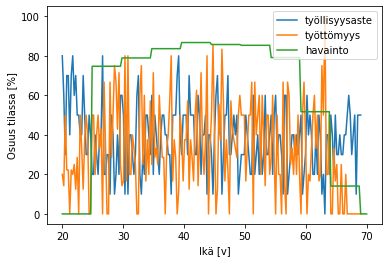

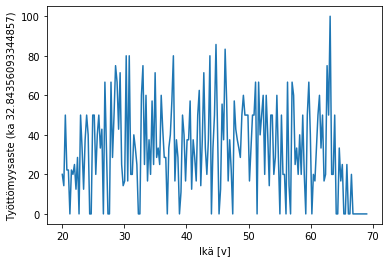

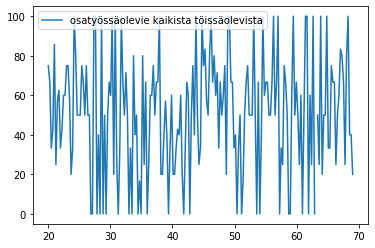

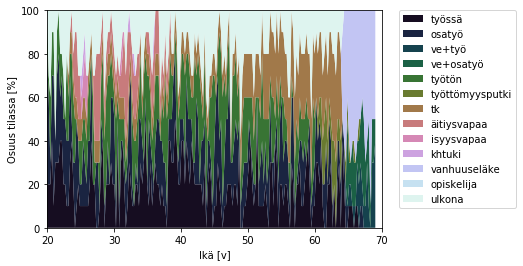

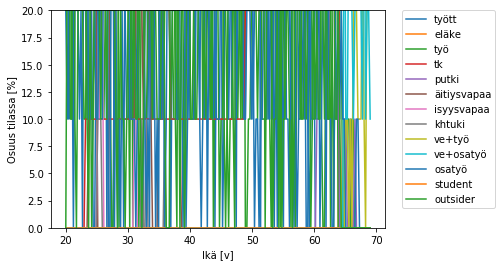

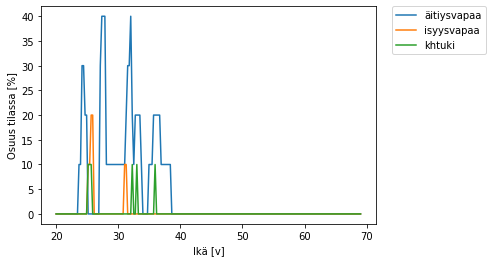

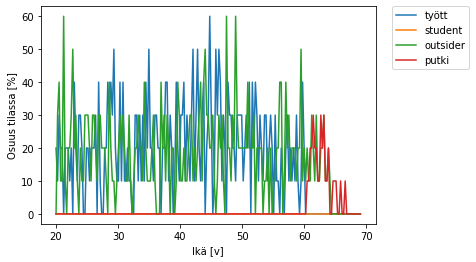

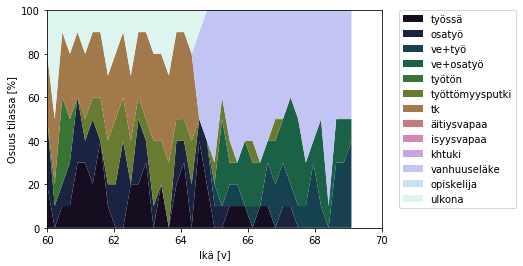

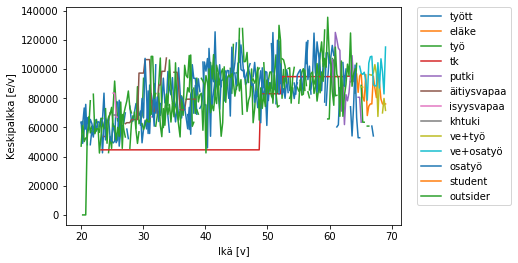

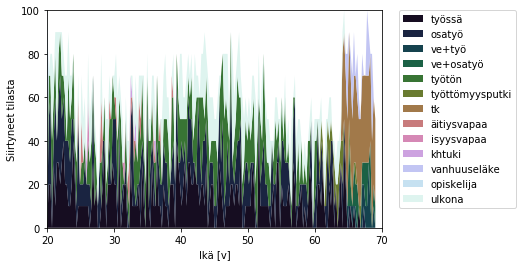

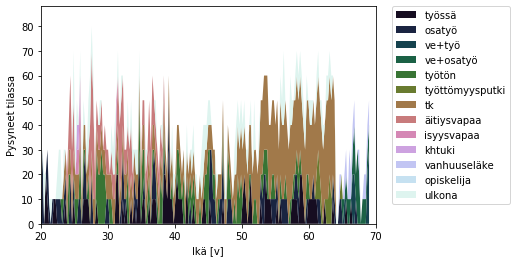

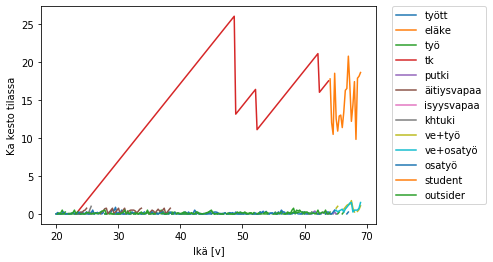

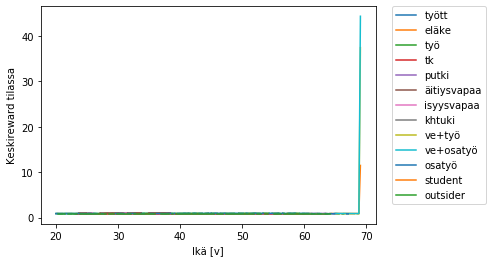

No handles with labels found to put in legend.


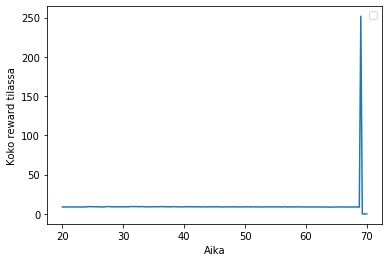

Yhteensä reward 2.0474391394690703


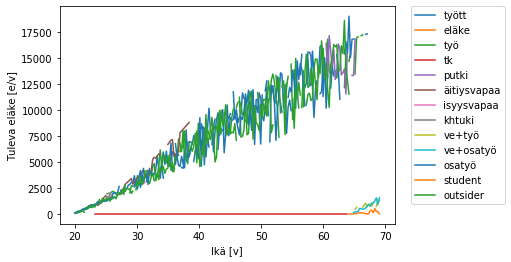

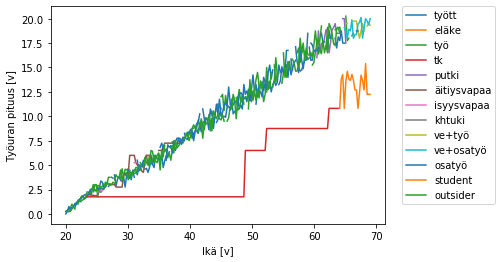

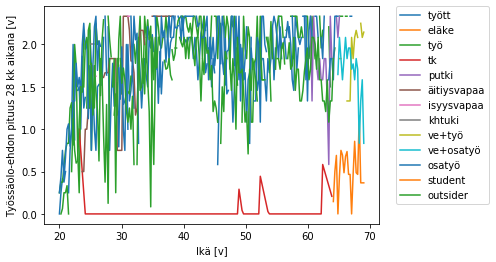

In [2]:
cc1=Lifecycle(env='unemployment-v1',minimal=False,mortality=mortality,perustulo=False,
              deterministic=deterministic,randomness=randomness)
cc1.render(load='results/simut_res_best')